In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load Dataset

In [2]:
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
from hcmus.data import LbsDataset

2025-04-12 16:35:01.113 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
torch_device = "cpu"
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["validation"],
)
lsb_dataset = LbsDataset(lsb_connector, device=appconfig.TORCH_DEVICE, augmentation=False)
lsb_dataloader = lsb_dataset.get_dataloader()

Loading tasks:   1%|          | 1/100 [00:01<02:54,  1.76s/it]
2025-04-12 16:35:05.085 | INFO     | hcmus.data._lbs_dataset:__init__:33 - Number of labels: 16
2025-04-12 16:35:05.085 | INFO     | hcmus.data._lbs_dataset:__init__:34 - Number of data points: 7


In [4]:
from ultralytics import YOLO
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load YOLOv8 model once
yolo_model = YOLO("yolov8n.pt")  # You can swap with yolov8s.pt, m.pt, l.pt etc.

def visualize_yolo_predictions(img_pil, target, yolo_result, conf_threshold=0.25):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_pil)

    # Ground truth (green)
    if target:
        for box in target["boxes"]:
            x1, y1, x2, y2 = box.cpu()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

    # YOLO Predictions (red)
    for box, score in zip(yolo_result.boxes.xyxy, yolo_result.boxes.conf):
        if score < conf_threshold:
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f'{score:.2f}', color='white', fontsize=8,
                bbox=dict(facecolor='red', edgecolor='none', pad=1))

    plt.axis('off')
    plt.show()


def test_one_batch(dataloader, conf_threshold=0.25):
    for images, targets in dataloader:
        # Batch assumed to be list of tensors (C, H, W)
        for i in range(len(images)):
            img_tensor = images[i].cpu()
            img_pil = to_pil_image(img_tensor)
            result = yolo_model.predict(img_pil, conf=conf_threshold, verbose=False)[0]
            visualize_yolo_predictions(img_pil, targets[i], result, conf_threshold)
        break  # Remove this to process the entire dataset


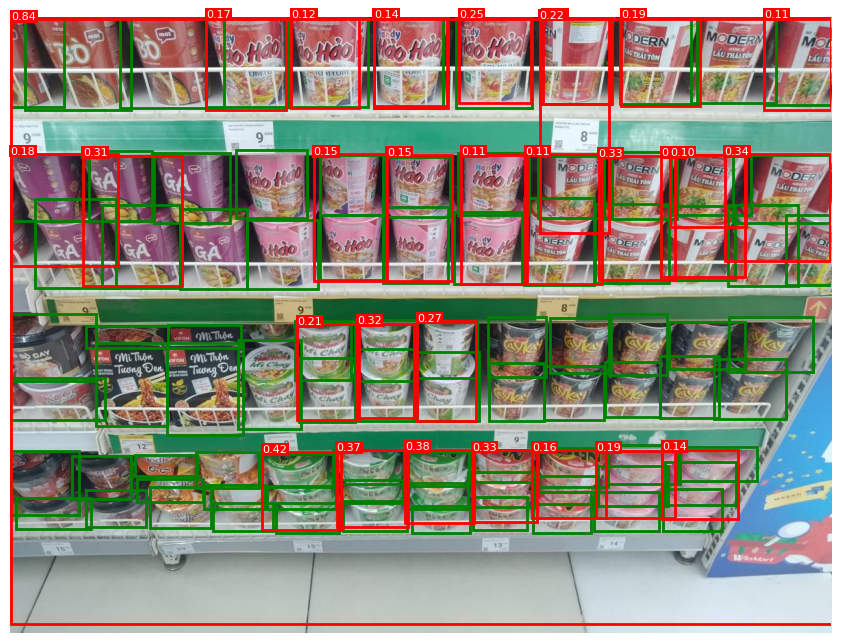

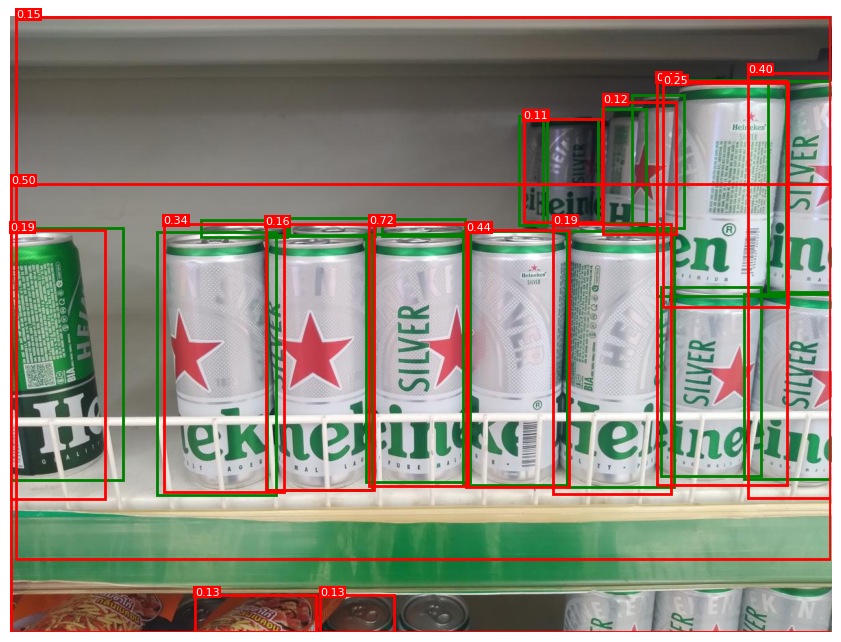

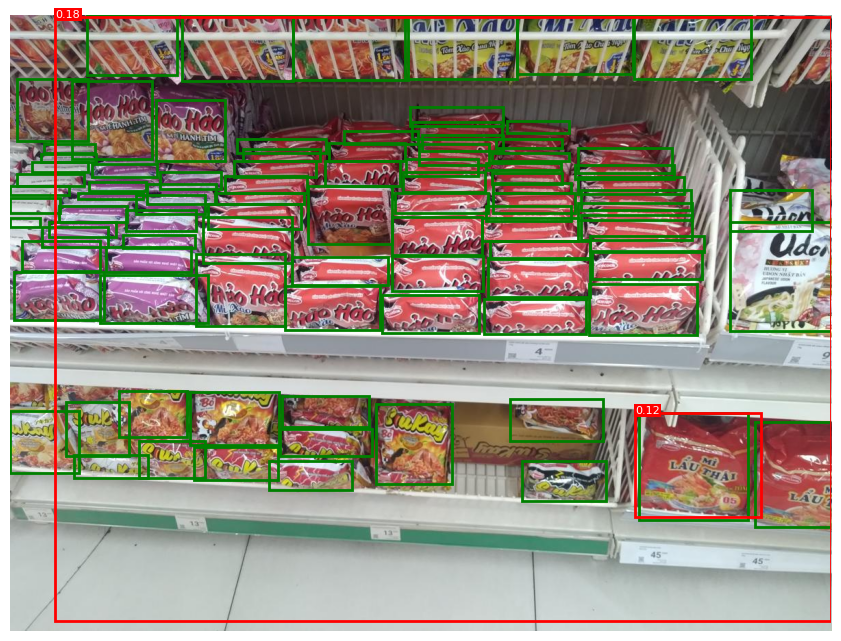

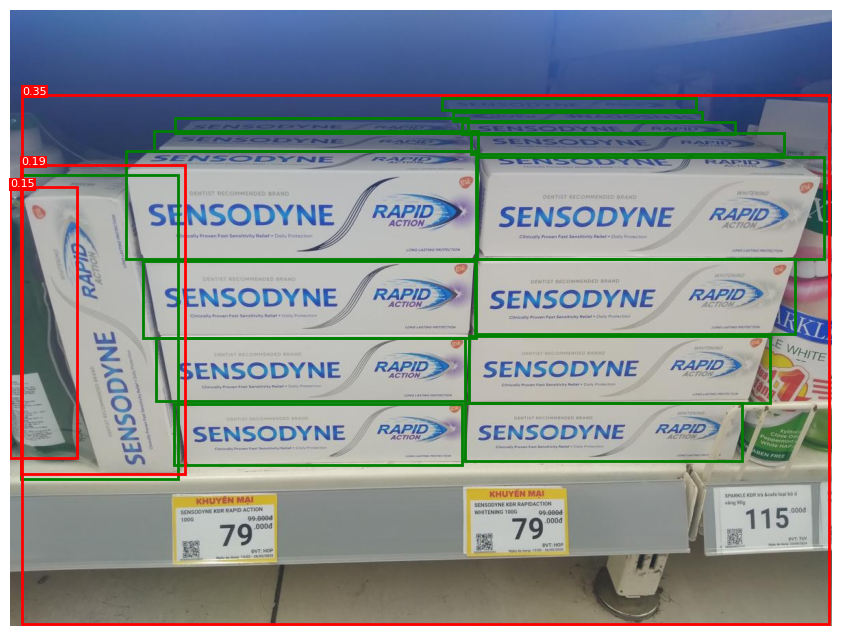

In [6]:
test_one_batch(lsb_dataloader, 0.1)